In [1]:
import zipfile
import os

# Paths of uploaded files
zip_files = ["dogcat.zip", "liontiger.zip"]
extract_paths = ["/content/dogcat_dataset", "/content/liontiger_dataset"]

# Unzip both safely
for zip_file, path in zip(zip_files, extract_paths):
    os.makedirs(path, exist_ok=True)
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(path)
        print(f" Successfully extracted {zip_file} → {path}")
        print("Subfolders:", os.listdir(path))
    except zipfile.BadZipFile:
        print(f"ERROR: {zip_file} is not a valid ZIP or is corrupted.")
    except Exception as e:
        print(f"Unexpected error while extracting {zip_file}: {e}")


 Successfully extracted dogcat.zip → /content/dogcat_dataset
Subfolders: ['PetImages', 'labtask12.ipynb']
 Successfully extracted liontiger.zip → /content/liontiger_dataset
Subfolders: ['test', 'train']


In [ ]:
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

print("Libraries imported successfully!")

# =========================================================
# STEP 1: DEFINE DATA PATHS (ALREADY EXTRACTED)
# =========================================================
dogcat_root = "/content/dogcat_dataset/PetImages"     # Contains 'Cat', 'Dog'
liontiger_root = "/content/liontiger_dataset"          # Contains 'train', 'test'

# Final merged dataset folders
merged_train = "/content/merged_train"
merged_test = "/content/merged_test"

classes = ["lion", "tiger", "cat", "dog"]

# Create folders
for folder in [merged_train, merged_test]:
    for cls in classes:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# =========================================================
# STEP 2: COPY LION & TIGER IMAGES DIRECTLY
# =========================================================
for cls in ["lion", "tiger"]:
    # Train
    src_train = os.path.join(liontiger_root, "train", cls)
    dst_train = os.path.join(merged_train, cls)
    for img in os.listdir(src_train):
        if img.lower().endswith((".jpg", ".png")):
            shutil.copy(os.path.join(src_train, img), dst_train)
    # Test
    src_test = os.path.join(liontiger_root, "test", cls)
    dst_test = os.path.join(merged_test, cls)
    for img in os.listdir(src_test):
        if img.lower().endswith((".jpg", ".png")):
            shutil.copy(os.path.join(src_test, img), dst_test)

print("✅ Copied Lion/Tiger data.")

# =========================================================
# STEP 3: PREPARE CAT & DOG IMAGES (DOWNSAMPLE & SPLIT)
# =========================================================
for cls in ["Cat", "Dog"]:
    src_folder = os.path.join(dogcat_root, cls)
    imgs = [f for f in os.listdir(src_folder) if f.lower().endswith((".jpg", ".png"))]
    imgs = imgs[:1500]  # downsample for balance

    train_imgs, test_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    # Train
    dst_train = os.path.join(merged_train, cls.lower())
    for img in train_imgs:
        shutil.copy(os.path.join(src_folder, img), dst_train)

    # Test
    dst_test = os.path.join(merged_test, cls.lower())
    for img in test_imgs:
        shutil.copy(os.path.join(src_folder, img), dst_test)

print("✅ Processed Cat/Dog data.")

# =========================================================
# STEP 4: SHOW IMAGE COUNTS & SAMPLES
# =========================================================
for cls in classes:
    print(f"{cls}: Train={len(os.listdir(os.path.join(merged_train, cls)))}, "
          f"Test={len(os.listdir(os.path.join(merged_test, cls)))}")

# Bar chart
plt.bar(classes, [len(os.listdir(os.path.join(merged_train, c))) for c in classes],
        color=['orange', 'gray', 'blue', 'green'])
plt.title("Training Images per Class")
plt.show()

# Show one sample per class
fig, axes = plt.subplots(1, len(classes), figsize=(16, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(merged_train, cls, os.listdir(os.path.join(merged_train, cls))[0])
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.show()

# =========================================================
# STEP 5: DATA GENERATORS
# =========================================================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    merged_train, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)
val_gen = train_datagen.flow_from_directory(
    merged_train, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)
test_gen = test_datagen.flow_from_directory(
    merged_test, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

# =========================================================
# STEP 6: TRANSFER LEARNING (ResNet50)
# =========================================================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Unfreeze last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# =========================================================
# STEP 7: TRAIN THE MODEL
# =========================================================
history = model.fit(train_gen, validation_data=val_gen, epochs=25)

# =========================================================
# STEP 8: ACCURACY & LOSS PLOTS
# =========================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =========================================================
# STEP 9: EVALUATE ON TEST DATA
# =========================================================
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# =========================================================
# STEP 10: CONFUSION MATRIX & REPORT
# =========================================================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


In [5]:
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

print("Libraries imported successfully!")

# =========================================================
# STEP 1: DEFINE DATA PATHS (ALREADY EXTRACTED)
# =========================================================
dogcat_root = "/content/dogcat_dataset/PetImages"     # Contains 'Cat', 'Dog'
liontiger_root = "/content/liontiger_dataset"          # Contains 'train', 'test'

# Final merged dataset folders
merged_train = "/content/merged_train"
merged_test = "/content/merged_test"

classes = ["lion", "tiger", "cat", "dog"]

# Create folders
for folder in [merged_train, merged_test]:
    for cls in classes:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# =========================================================
# STEP 2: COPY LION & TIGER IMAGES DIRECTLY
# =========================================================
for cls in ["lion", "tiger"]:
    # Train
    src_train = os.path.join(liontiger_root, "train", cls)
    dst_train = os.path.join(merged_train, cls)
    for img in os.listdir(src_train):
        if img.lower().endswith((".jpg", ".png")):
            shutil.copy(os.path.join(src_train, img), dst_train)
    # Test
    src_test = os.path.join(liontiger_root, "test", cls)
    dst_test = os.path.join(merged_test, cls)
    for img in os.listdir(src_test):
        if img.lower().endswith((".jpg", ".png")):
            shutil.copy(os.path.join(src_test, img), dst_test)

print("Copied Lion/Tiger data.")






Libraries imported successfully!
Copied Lion/Tiger data.


**PREPARE CAT & DOG IMAGES (DOWNSAMPLE & SPLIT)**

In [6]:

for cls in ["Cat", "Dog"]:
    src_folder = os.path.join(dogcat_root, cls)
    imgs = [f for f in os.listdir(src_folder) if f.lower().endswith((".jpg", ".png"))]
    imgs = imgs[:1500]  # downsample for balance

    train_imgs, test_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    # Train
    dst_train = os.path.join(merged_train, cls.lower())
    for img in train_imgs:
        shutil.copy(os.path.join(src_folder, img), dst_train)

    # Test
    dst_test = os.path.join(merged_test, cls.lower())
    for img in test_imgs:
        shutil.copy(os.path.join(src_folder, img), dst_test)

print("Processed Cat/Dog data.")



Processed Cat/Dog data.


lion: Train=180, Test=20
tiger: Train=180, Test=20
cat: Train=1200, Test=300
dog: Train=1200, Test=300


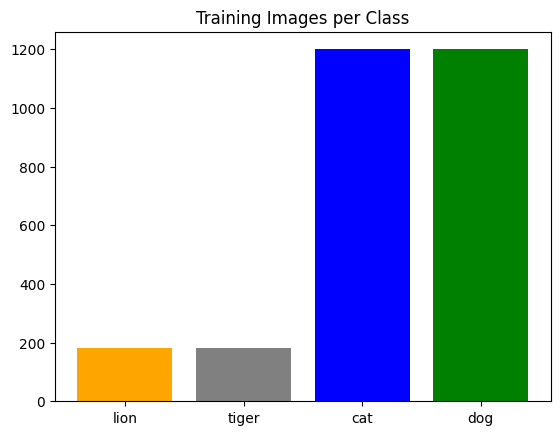

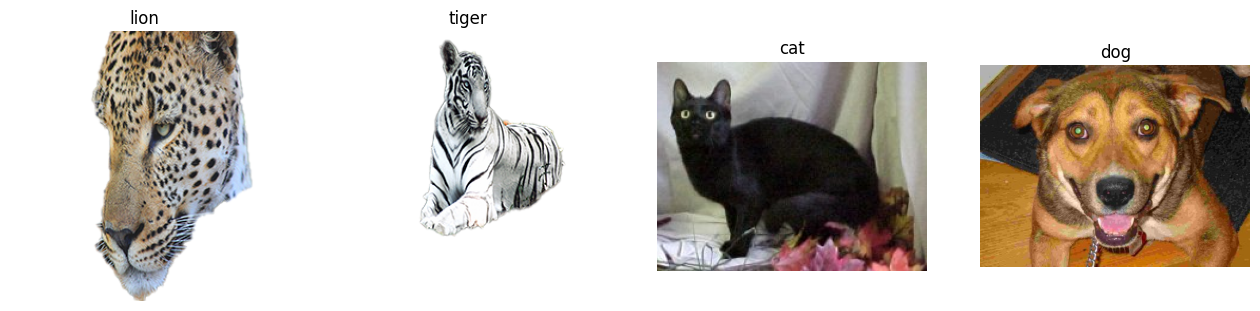

In [8]:
for cls in classes:
    print(f"{cls}: Train={len(os.listdir(os.path.join(merged_train, cls)))}, "
          f"Test={len(os.listdir(os.path.join(merged_test, cls)))}")

# Bar chart
plt.bar(classes, [len(os.listdir(os.path.join(merged_train, c))) for c in classes],
        color=['orange', 'gray', 'blue', 'green'])
plt.title("Training Images per Class")
plt.show()

# Show one sample per class
fig, axes = plt.subplots(1, len(classes), figsize=(16, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(merged_train, cls, os.listdir(os.path.join(merged_train, cls))[0])
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.show()

** DATA GENERATORS**

In [9]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    merged_train, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)
val_gen = train_datagen.flow_from_directory(
    merged_train, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)
test_gen = test_datagen.flow_from_directory(
    merged_test, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 2208 images belonging to 4 classes.
Found 552 images belonging to 4 classes.
Found 640 images belonging to 4 classes.


**TRANSFER LEARNING (ResNet50)**

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Unfreeze last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 14,975,748 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [11]:
# =========================================================
# STEP 7: TRAIN THE MODEL
# =========================================================
history = model.fit(train_gen, validation_data=val_gen, epochs=25)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 735s 10s/step - accuracy: 0.4878 - loss: 1.0314 - val_accuracy: 0.4366 - val_loss: 1.1798
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 671s 10s/step - accuracy: 0.6244 - loss: 0.7391 - val_accuracy: 0.4475 - val_loss: 1.1977
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 662s 10s/step - accuracy: 0.6292 - loss: 0.7039 - val_accuracy: 0.5145 - val_loss: 0.9976
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 696s 10s/step - accuracy: 0.6502 - loss: 0.6684 - val_accuracy: 0.4801 - val_loss: 2.0530
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 749s 10s/step - accuracy: 0.6459 - loss: 0.6873 - val_accuracy: 0.6141 - val_loss: 0.7851
Epoch 6/25
 1/69 ━━━━━━━━━━━━━━━━━━━━ 10:57 10s/step - accuracy: 0.7188 - loss: 0.5760

KeyboardInterrupt: 

**ACCURACY & LOSS PLOTS**

NameError: name 'history' is not defined

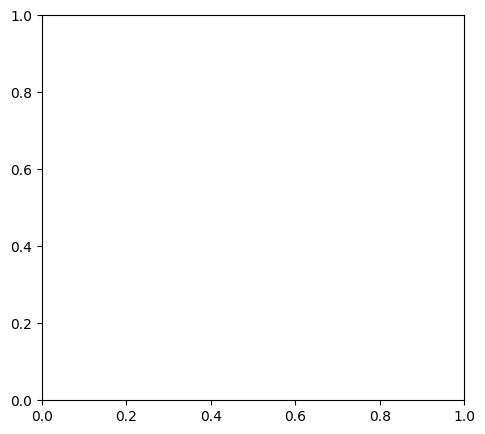

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**EVALUATE ON TEST DATA**

In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.4379 - loss: 0.9355
Test Accuracy: 60.62%


**CONFUSION MATRIX & REPORT**

20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step


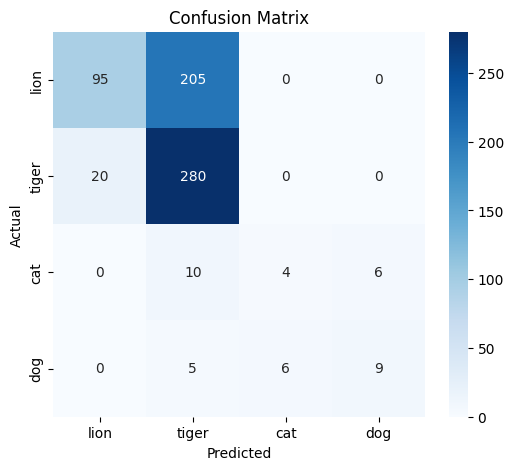


Classification Report:
              precision    recall  f1-score   support

        lion       0.83      0.32      0.46       300
       tiger       0.56      0.93      0.70       300
         cat       0.40      0.20      0.27        20
         dog       0.60      0.45      0.51        20

    accuracy                           0.61       640
   macro avg       0.60      0.47      0.48       640
weighted avg       0.68      0.61      0.57       640



In [14]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))